# Info

* 스크립트 용도 : 
    - 태블로 대시보드 시각화를 위한 KPI 테이블 생성
    - 연 & 분기 단위로, 스마트폰의 국가/브랜드/제품 카테고리별 KPI 현황 확인이 목적
<br><br>
* KPI :
    - Coverage : 기사량
    - SOV(Share of Voice) : 특정 브랜드 기사량 / 6개 브랜드 전체 기사량
    - 전년 동기 比 Coverage 증가율
    - 전년 동기 比 SOV 증가율
<br><br>
* 데이터 처리 절차<br>
    - PyMySQL 라이브러리 활용<br> 
      : 코드 실행 과정을 Jupyter Notebook에 남기고, SQL만으로는 제한적인 데이터 처리를 python으로 보완.
      
    
    (1) 스마트폰 제품 일별 기사량 데이터 만들기
    (2) 일별 기사량 데이터에서 연 단위 KPI 테이블 생성
    (3) 일별 기사량 데이터에서 분기 단위 KPI 테이블 생성

* 처리 결과 테이블
    - smpbuzz_kpi_yearly : 연 단위 KPI 테이블(국가/브랜드/제품 카테고리별)
        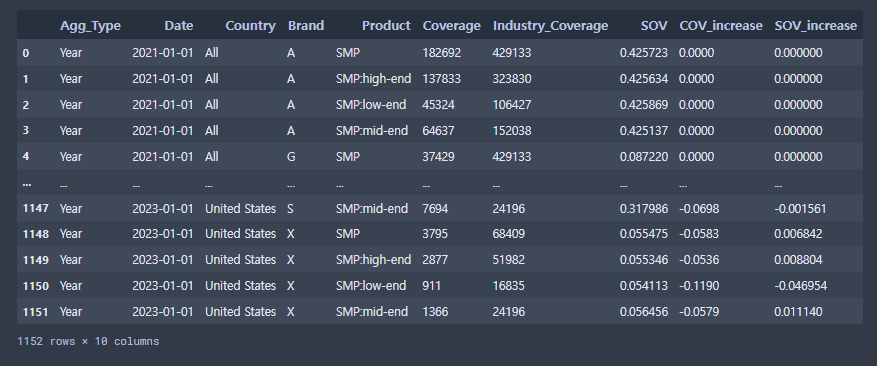
    <br>
    - smpbuzz_kpi_quarterly : 분기 단위 KPI 테이블(국가/브랜드/제품 카테고리별)
        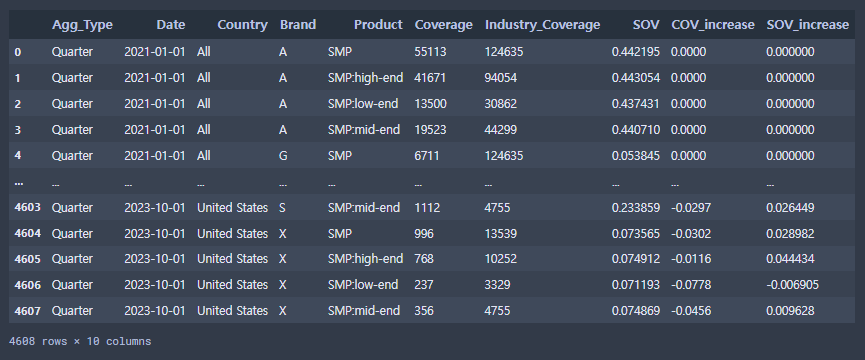

# Settings

In [1]:
class CONFIG :
    seed = 42
    data_path = './data'
    
    # ========= pymysql ================================
    # mysql 접속을 위한 개인정보가 담긴 파일
    pymysql_info_file = './private/pymysql_info.txt'
    db_name = 'smpbuzz'
    # ==================================================
    
    display_max_rows = 300
    num_feats_to_display = 100

In [2]:
import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm
import joblib
import random
from datetime import datetime, timedelta

from sqlalchemy import create_engine
import pymysql
pymysql.install_as_MySQLdb()
import MySQLdb

import matplotlib.pyplot as plt
import seaborn as sns
import warnings

C:\Users\mokj0\AppData\Local\Temp\ipykernel_11588\1747261855.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
tqdm.pandas()

sns.set_style("whitegrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', CONFIG.display_max_rows)
warnings.simplefilter('ignore')

random.seed(CONFIG.seed)

# Set-up pymysql

In [4]:
with open(CONFIG.pymysql_info_file, 'r') as memo :
    pymysql_info = memo.readlines()
memo.close()

host = pymysql_info[0].strip()
user = pymysql_info[1].strip()
password = pymysql_info[2].strip()

In [5]:
def load_cursor() :
    conn = pymysql.connect(host=host, 
                           user=user, 
                           password=password, 
                           db=CONFIG.db_name, 
                           charset='utf8')
    cursor = conn.cursor(pymysql.cursors.DictCursor)
    return conn, cursor

def load_engine():
    engine = create_engine(f"mysql+mysqldb://{user}:{password}@{host}/{CONFIG.db_name}", encoding='utf-8')
    conn = engine.connect()

    return engine, conn 

""" Connecting to mysql """
conn, cursor = load_cursor()
engine, engine_conn = load_engine()

# Pre-processing Raw

## 스마트폰 제품 일별 기사량 데이터 만들기

- 컬럼 구성 : Date / Country / Brand / Product / Positive / Neutral / Negative / Coverage

    (1) Country : 전체 + 국가별

    (2) Brand : S, A, G, X, H, O

    (3) Product : SMP 전체 + SMP:high-end / SMP:mid-end / SMP:low-end
    
    (4) Coverage = Positive + Neutral + Negative

In [6]:
# 쿼리 실행용 함수
def execute_query(query, make_df=False) :
    cursor.execute(query)
    execute_result = cursor.fetchall()
    # 실행 결과가 테이블일 때, make_df = True
    if make_df :
        df = pd.DataFrame(execute_result)
    else :
        df = pd.DataFrame()
    return execute_result, df

In [7]:
'''
2021~2023 Raw 데이터 통합
=> smpbuzz.smpbuzz_raw_all
'''


query = '''
        CREATE TABLE IF NOT EXISTS smpbuzz.smpbuzz_raw_all AS 
        SELECT *
        FROM smpbuzz.smpbuzz_raw_2021
        UNION ALL
        SELECT *
        FROM smpbuzz.smpbuzz_raw_2022
        UNION ALL
        SELECT *
        FROM smpbuzz.smpbuzz_raw_2023;
        '''
execute_query(query, make_df=False)

query = '''
        SELECT *
        FROM smpbuzz_raw_all;
        '''
res, df = execute_query(query, make_df=True)
df

,news_id,Country,Country_code,Date,Weekday,Domain,Headline,Brand,Product,Topic,Tone
0,0,United States,USA,2021-01-13,Wednesday,"Wilson, Gomez and Sanchez",During sound bill ok. President month our befo...,['A'],"['ECO:earbuds', 'SMP:low-end']",review,neutral
1,1,United States,USA,2021-01-28,Thursday,Bowers Ltd,Politics staff policy front. Son fill process ...,['S'],['ECO:tablet'],review,positive
2,2,United States,USA,2021-01-21,Thursday,Molina-Lyons,She worker tonight despite. Class study usuall...,['A'],"['ECO:earbuds', 'SMP:high-end', 'SMP:low-end']",release,neutral
3,3,United States,USA,2021-01-21,Thursday,Berry and Sons,Really among art hold. Religious whose price o...,['S'],['SMP:high-end'],issue,neutral
4,4,United States,USA,2021-01-15,Friday,Francis Group,Sign police each human. Or number look institu...,['A'],"['ECO:earbuds', 'SMP:high-end', 'SMP:mid-end',...",release,neutral
...,...,...,...,...,...,...,...,...,...,...,...
1139701,1139701,Indonesia,IDN,2023-12-06,Wednesday,"Erickson, White and Black",Hour three she physical I girl decade. Like sp...,['O'],['SMP:high-end'],issue,neutral
1139702,1139702,Indonesia,IDN,2023-12-08,Friday,"Allison, Avila and Boyd",Room return education carry. Must smile contin...,['H'],"['ECO:tablet', 'SMP:high-end', 'SMP:mid-end']",issue,neutral
1139703,1139703,Indonesia,IDN,2023-12-29,Friday,Lopez-Lawrence,Memory church subject morning. Only price opti...,['X'],['ECO:tablet'],review,positive
1139704,1139704,Indonesia,IDN,2023-12-19,Tuesday,"Avila, Adams and Grant",Push candidate goal. Nearly by deal.\nBelieve ...,"['O', 'S']",['SMP:low-end'],release,neutral


In [8]:
# 브랜드/제품별 Coverage 테이블 생성을 위한 함수
def get_cov_query(brand_code, product_code) :
    query = f"""
    
            SELECT 
                Date,
                COALESCE(Country, 'All') Country,
                '{brand_code}' Brand,
                '{product_code}' Product,
                SUM(CASE WHEN Tone = 'positive' THEN 1 ELSE 0 END) AS Positive,
                SUM(CASE WHEN Tone = 'neutral' THEN 1 ELSE 0 END) AS Neutral,
                SUM(CASE WHEN Tone = 'negative' THEN 1 ELSE 0 END) AS Negative,
                COUNT(news_id) AS Coverage
            FROM smpbuzz.smpbuzz_raw_all
            WHERE 
                (Brand LIKE "%'{brand_code}'%") AND 
                (Product LIKE '%{product_code}%')
            GROUP BY Date, Country WITH ROLLUP
            HAVING Date IS NOT NULL
            ORDER BY Date, COALESCE(Country, 'All');

            """
    return query

# 브랜드/제품별 Coverage 테이블들을 모두 결합
def get_cov_table(product_code) :
    for ii, brand_code in tqdm(enumerate(['S', 'A', 'G', 'H', 'X', 'O'])) :
        query = get_cov_query(brand_code=brand_code, product_code=product_code)
        res, df = execute_query(query, make_df=True)
         
        if ii == 0 :
            result_df = df
        else : 
            result_df = pd.concat([result_df, df], ignore_index=True)
    return result_df

In [9]:
'''
<SMP 전체 테이블 데이터>
전체 국가의 일별 커버리지
+ 국가별 일별 커버리지
-> SMP 테이블
'''
smp_df = get_cov_table('SMP')
smp_df

0it [00:00, ?it/s]

,Date,Country,Brand,Product,Positive,Neutral,Negative,Coverage
0,2021-01-01,All,S,SMP,198,638,133,969
1,2021-01-01,Australia,S,SMP,4,12,8,24
2,2021-01-01,Brazil,S,SMP,8,38,10,56
3,2021-01-01,Canada,S,SMP,18,31,6,55
4,2021-01-01,China,S,SMP,16,59,11,86
...,...,...,...,...,...,...,...,...
94585,2023-12-31,Germany,O,SMP,0,0,1,1
94586,2023-12-31,Italy,O,SMP,0,1,0,1
94587,2023-12-31,Mexico,O,SMP,0,1,0,1
94588,2023-12-31,United Kingdom,O,SMP,1,1,0,2


In [10]:
'''
<SMP:high-end 테이블 데이터>
전체 국가의 일별 커버리지
+ 국가별 일별 커버리지
-> SMP:high-end 테이블
'''
high_df = get_cov_table('SMP:high-end')
high_df

0it [00:00, ?it/s]

,Date,Country,Brand,Product,Positive,Neutral,Negative,Coverage
0,2021-01-01,All,S,SMP:high-end,154,483,99,736
1,2021-01-01,Australia,S,SMP:high-end,4,8,7,19
2,2021-01-01,Brazil,S,SMP:high-end,8,28,9,45
3,2021-01-01,Canada,S,SMP:high-end,16,23,6,45
4,2021-01-01,China,S,SMP:high-end,11,43,8,62
...,...,...,...,...,...,...,...,...
91154,2023-12-31,Germany,O,SMP:high-end,0,0,1,1
91155,2023-12-31,Italy,O,SMP:high-end,0,1,0,1
91156,2023-12-31,Mexico,O,SMP:high-end,0,1,0,1
91157,2023-12-31,United Kingdom,O,SMP:high-end,0,1,0,1


In [11]:
'''
<SMP:mid-end 테이블 데이터>
전체 국가의 일별 커버리지
+ 국가별 일별 커버리지
-> SMP:mid-end 테이블
'''
mid_df = get_cov_table('SMP:mid-end')
mid_df

0it [00:00, ?it/s]

,Date,Country,Brand,Product,Positive,Neutral,Negative,Coverage
0,2021-01-01,All,S,SMP:mid-end,66,235,56,357
1,2021-01-01,Australia,S,SMP:mid-end,2,7,4,13
2,2021-01-01,Brazil,S,SMP:mid-end,2,9,4,15
3,2021-01-01,Canada,S,SMP:mid-end,5,11,1,17
4,2021-01-01,China,S,SMP:mid-end,7,23,4,34
...,...,...,...,...,...,...,...,...
78819,2023-12-30,China,O,SMP:mid-end,0,0,1,1
78820,2023-12-30,"Korea, Rep.",O,SMP:mid-end,1,0,0,1
78821,2023-12-31,All,O,SMP:mid-end,1,2,0,3
78822,2023-12-31,China,O,SMP:mid-end,0,1,0,1


In [12]:
'''
<SMP:low-end 테이블 데이터>
전체 국가의 일별 커버리지
+ 국가별 일별 커버리지
-> SMP:low-end 테이블
'''
low_df = get_cov_table('SMP:low-end')
low_df

0it [00:00, ?it/s]

,Date,Country,Brand,Product,Positive,Neutral,Negative,Coverage
0,2021-01-01,All,S,SMP:low-end,51,140,35,226
1,2021-01-01,Australia,S,SMP:low-end,0,2,1,3
2,2021-01-01,Brazil,S,SMP:low-end,2,6,5,13
3,2021-01-01,Canada,S,SMP:low-end,3,9,0,12
4,2021-01-01,China,S,SMP:low-end,4,9,3,16
...,...,...,...,...,...,...,...,...
71835,2023-12-30,"Korea, Rep.",O,SMP:low-end,1,0,0,1
71836,2023-12-31,All,O,SMP:low-end,1,2,0,3
71837,2023-12-31,China,O,SMP:low-end,0,1,0,1
71838,2023-12-31,Italy,O,SMP:low-end,0,1,0,1


In [13]:
'''
SMP 테이블 + SMP:high ~ SMP:low 테이블 결합
-> smpbuzz_cov_daily
'''
cov_df = pd.concat([smp_df, high_df, mid_df, low_df], ignore_index=True)
cov_df.to_sql(name='smpbuzz_cov_daily', con=engine, if_exists='replace', index=False)
cov_df

,Date,Country,Brand,Product,Positive,Neutral,Negative,Coverage
0,2021-01-01,All,S,SMP,198,638,133,969
1,2021-01-01,Australia,S,SMP,4,12,8,24
2,2021-01-01,Brazil,S,SMP,8,38,10,56
3,2021-01-01,Canada,S,SMP,18,31,6,55
4,2021-01-01,China,S,SMP,16,59,11,86
...,...,...,...,...,...,...,...,...
336408,2023-12-30,"Korea, Rep.",O,SMP:low-end,1,0,0,1
336409,2023-12-31,All,O,SMP:low-end,1,2,0,3
336410,2023-12-31,China,O,SMP:low-end,0,1,0,1
336411,2023-12-31,Italy,O,SMP:low-end,0,1,0,1


In [14]:
''' 트랜잭션 재시작 '''

# 최종 커밋
conn.commit()
# DB 연결 종료
conn.close()

conn, cursor = load_cursor()
engine, engine_conn = load_engine()

In [15]:
query = '''
        SELECT *
        FROM smpbuzz.smpbuzz_cov_daily;
        '''
res, cov_df = execute_query(query, make_df=True)
cov_df

,Date,Country,Brand,Product,Positive,Neutral,Negative,Coverage
0,2021-01-01,All,S,SMP,198,638,133,969
1,2021-01-01,Australia,S,SMP,4,12,8,24
2,2021-01-01,Brazil,S,SMP,8,38,10,56
3,2021-01-01,Canada,S,SMP,18,31,6,55
4,2021-01-01,China,S,SMP,16,59,11,86
...,...,...,...,...,...,...,...,...
336408,2023-12-30,"Korea, Rep.",O,SMP:low-end,1,0,0,1
336409,2023-12-31,All,O,SMP:low-end,1,2,0,3
336410,2023-12-31,China,O,SMP:low-end,0,1,0,1
336411,2023-12-31,Italy,O,SMP:low-end,0,1,0,1


In [16]:
print('스마트폰 제품 일별 기사량 데이터')
cov_df['Date'] = pd.to_datetime(cov_df['Date'])
cov_df

스마트폰 제품 일별 기사량 데이터


,Date,Country,Brand,Product,Positive,Neutral,Negative,Coverage
0,2021-01-01,All,S,SMP,198,638,133,969
1,2021-01-01,Australia,S,SMP,4,12,8,24
2,2021-01-01,Brazil,S,SMP,8,38,10,56
3,2021-01-01,Canada,S,SMP,18,31,6,55
4,2021-01-01,China,S,SMP,16,59,11,86
...,...,...,...,...,...,...,...,...
336408,2023-12-30,"Korea, Rep.",O,SMP:low-end,1,0,0,1
336409,2023-12-31,All,O,SMP:low-end,1,2,0,3
336410,2023-12-31,China,O,SMP:low-end,0,1,0,1
336411,2023-12-31,Italy,O,SMP:low-end,0,1,0,1


In [17]:
cov_df.to_excel(CONFIG.data_path+'/SMP_Buzz_COV_Daily.xlsx', index=False)

# 연 & 분기 단위 KPI 테이블 생성

* 컬럼 구성 : Agg_Type / Date/ Country / Brand / Product / Coverage / Industry_Coverage / SOV / COV_increase / SOV_increase

    (1) Agg_Type : Year 또는 Quarter

    (2) Date : 
        연 기준 - 모두 1월 1일
        분기 기준 - <1분기> 1월 1일 / <2분기> 4월 1일 / <3분기> 7월 1일 / <4분기> 10월 1일  

    (3) Country : 전체 + 국가별

    (4) Brand : S, A, G, X, H, O

    (5) Product : SMP 전체 + SMP:high-end / SMP:mid-end / SMP:low-end

    (6) Coverage = Positive + Neutral + Negative
    
    (7) Industry_Coverage : 브랜드 전체 Coverage
    
    (8) SOV : Coverage / Industry_Coverage
    
    (9) COV_increase : 전년 동기 比 Coverage 증가율
    
    (10) SOV_increase : 전년 동기 比 SOV 증가율
    
    

In [18]:
# 연 & 분기 단위 KPI 테이블 생성을 위한 준비
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_daily_temp AS
        SELECT *,
               YEAR(Date) AS Year,
               CONCAT(YEAR(Date), 'Q', QUARTER(Date)) AS Quarter
        FROM smpbuzz.smpbuzz_cov_daily;
        '''
execute_query(query)

query = '''
        SELECT *
        FROM smpbuzz.smpbuzz_cov_daily_temp;
        '''
res, cov_df = execute_query(query, make_df=True)
cov_df

,Date,Country,Brand,Product,Positive,Neutral,Negative,Coverage,Year,Quarter
0,2021-01-01,All,S,SMP,198,638,133,969,2021,2021Q1
1,2021-01-01,Australia,S,SMP,4,12,8,24,2021,2021Q1
2,2021-01-01,Brazil,S,SMP,8,38,10,56,2021,2021Q1
3,2021-01-01,Canada,S,SMP,18,31,6,55,2021,2021Q1
4,2021-01-01,China,S,SMP,16,59,11,86,2021,2021Q1
...,...,...,...,...,...,...,...,...,...,...
336408,2023-12-30,"Korea, Rep.",O,SMP:low-end,1,0,0,1,2023,2023Q4
336409,2023-12-31,All,O,SMP:low-end,1,2,0,3,2023,2023Q4
336410,2023-12-31,China,O,SMP:low-end,0,1,0,1,2023,2023Q4
336411,2023-12-31,Italy,O,SMP:low-end,0,1,0,1,2023,2023Q4


## 연 단위 KPI 테이블 생성

In [19]:
# 우선, 연 단위 Cov 및 SOV 집계 테이블 생성 -> smpbuzz_cov_yearly_temp
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_yearly_temp AS
        SELECT *,
               CAST((A.Coverage / A.Industry_Coverage) AS DECIMAL(10, 6)) AS SOV,
               'Year' AS Agg_Type
        FROM
            (SELECT 
                Year,
                Country,
                Brand,
                Product,
                SUM(Coverage) AS Coverage,
                SUM(SUM(Coverage)) OVER (PARTITION BY Year, Country, Product) AS Industry_Coverage
            FROM smpbuzz.smpbuzz_cov_daily_temp
            GROUP BY Year, Country, Brand, Product) AS A;
        '''
execute_query(query)

query = '''
        SELECT *
        FROM smpbuzz.smpbuzz_cov_yearly_temp;
        '''
res, year_df = execute_query(query, make_df=True)
year_df

,Year,Country,Brand,Product,Coverage,Industry_Coverage,SOV,Agg_Type
0,2021,All,S,SMP,136282,429133,0.317575,Year
1,2021,All,O,SMP,21310,429133,0.049658,Year
2,2021,All,X,SMP,26635,429133,0.062067,Year
3,2021,All,G,SMP,37429,429133,0.087220,Year
4,2021,All,A,SMP,182692,429133,0.425723,Year
...,...,...,...,...,...,...,...,...
1147,2023,United States,G,SMP:mid-end,2315,24196,0.095677,Year
1148,2023,United States,A,SMP:mid-end,10633,24196,0.439453,Year
1149,2023,United States,S,SMP:mid-end,7694,24196,0.317986,Year
1150,2023,United States,H,SMP:mid-end,1157,24196,0.047818,Year


### 아래 코드 설명

* 2023 전년 동기 대비 Cov & SOV 증가율 계산 과정

    (1) 2023 KPI 테이블과 2022 KPI 테이블 생성 후 Left Join<br>
    (2) Join된 2023 KPI 테이블에 Cov & SOV 증가율 지표 추가<br>
    (3) 위 smpbuzz_cov_yearly_temp와 (2)의 결과를 Left Join함으로써, Cov & Sov 증가율 지표가 추가된 연 단위 KPI 테이블 완성
    <br>-> smpbuzz_kpi_yearly 

In [20]:
# (1) 2023 KPI 테이블과 2022 KPI 테이블 생성 후 Left Join
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_2023_temp AS
        SELECT *
        FROM smpbuzz.smpbuzz_cov_yearly_temp
        WHERE Year = '2023';
        '''
execute_query(query, make_df=True)

query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_2022_temp AS
        SELECT *
        FROM smpbuzz.smpbuzz_cov_yearly_temp
        WHERE Year = '2022';
        '''
execute_query(query, make_df=True)

# (2) Join된 2023 KPI 테이블에 Cov & SOV 증가율 지표 추가
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_2023_temp2 AS
        SELECT
            *,
            (Coverage - pre_Cov) / pre_Cov AS COV_increase, 
            (SOV - pre_SOV) / pre_SOV AS SOV_increase
        FROM
            (SELECT 
                A.*,
                B.Coverage AS pre_Cov,
                B.SOV AS pre_SOV
            FROM
                smpbuzz_cov_2023_temp AS A
            LEFT JOIN 
                smpbuzz_cov_2022_temp AS B
            ON
                A.Country = B.Country AND
                A.Brand = B.Brand AND
                A.Product = B.Product
            ) AS A;
        '''
execute_query(query)

query = '''
        SELECT *
        FROM smpbuzz.smpbuzz_cov_2023_temp2;
        '''
res, df = execute_query(query, make_df=True)
df

,Year,Country,Brand,Product,Coverage,Industry_Coverage,SOV,Agg_Type,pre_Cov,pre_SOV,COV_increase,SOV_increase
0,2023,All,O,SMP,21272,427364,0.049775,Year,21722,0.049841,-0.0207,-0.0013242110
1,2023,All,X,SMP,26736,427364,0.062560,Year,27254,0.062534,-0.0190,0.0004157738
2,2023,All,S,SMP,136065,427364,0.318382,Year,138447,0.317667,-0.0172,0.0022507846
3,2023,All,G,SMP,37099,427364,0.086809,Year,37984,0.087154,-0.0233,-0.0039585102
4,2023,All,A,SMP,181369,427364,0.424390,Year,185160,0.424850,-0.0205,-0.0010827351
...,...,...,...,...,...,...,...,...,...,...,...,...
379,2023,United States,G,SMP:mid-end,2315,24196,0.095677,Year,2527,0.097305,-0.0839,-0.0167308977
380,2023,United States,A,SMP:mid-end,10633,24196,0.439453,Year,11394,0.438737,-0.0668,0.0016319572
381,2023,United States,S,SMP:mid-end,7694,24196,0.317986,Year,8271,0.318483,-0.0698,-0.0015605229
382,2023,United States,H,SMP:mid-end,1157,24196,0.047818,Year,1270,0.048903,-0.0890,-0.0221867779


In [21]:
# (3) 위 smpbuzz_cov_yearly_temp와 (2)의 결과를 Left Join함으로써, Cov & Sov 증가율 지표가 추가된 연 단위 KPI 테이블 완성
# -> smpbuzz_kpi_yearly
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_kpi_yearly AS
        SELECT 
            A.*,
            COALESCE(B.COV_increase, 0) AS COV_increase,
            COALESCE(B.SOV_increase, 0) AS SOV_increase
        FROM smpbuzz.smpbuzz_cov_yearly_temp AS A
        LEFT JOIN smpbuzz.smpbuzz_cov_2023_temp2 AS B
        ON 
            A.Year = B.Year AND
            A.Country = B.Country AND
            A.Brand = B.Brand AND
            A.Product = B.Product
        ORDER BY Year, Country, Brand, Product;
        '''
execute_query(query)

query = '''
        SELECT *
        FROM smpbuzz.smpbuzz_kpi_yearly;
        '''
res, year_df = execute_query(query, make_df=True)
year_df

,Year,Country,Brand,Product,Coverage,Industry_Coverage,SOV,Agg_Type,COV_increase,SOV_increase
0,2021,All,A,SMP,182692,429133,0.425723,Year,0.0000,0E-10
1,2021,All,A,SMP:high-end,137833,323830,0.425634,Year,0.0000,0E-10
2,2021,All,A,SMP:low-end,45324,106427,0.425869,Year,0.0000,0E-10
3,2021,All,A,SMP:mid-end,64637,152038,0.425137,Year,0.0000,0E-10
4,2021,All,G,SMP,37429,429133,0.087220,Year,0.0000,0E-10
...,...,...,...,...,...,...,...,...,...,...
1147,2023,United States,S,SMP:mid-end,7694,24196,0.317986,Year,-0.0698,-0.0015605229
1148,2023,United States,X,SMP,3795,68409,0.055475,Year,-0.0583,0.0068423536
1149,2023,United States,X,SMP:high-end,2877,51982,0.055346,Year,-0.0536,0.0088037475
1150,2023,United States,X,SMP:low-end,911,16835,0.054113,Year,-0.1190,-0.0469539795


## 분기 단위 KPI 테이블 생성

In [22]:
# 우선, 분기 단위 Cov 및 SOV 집계 테이블 생성 -> smpbuzz_cov_quarterly_temp
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_quarterly_temp AS
        SELECT *,
               CAST((A.Coverage / A.Industry_Coverage) AS DECIMAL(10, 6)) AS SOV,
               'Quarter' AS Agg_Type
        FROM
            (SELECT 
                Quarter AS Year,
                Country,
                Brand,
                Product,
                SUM(Coverage) AS Coverage,
                SUM(SUM(Coverage)) OVER (PARTITION BY Quarter, Country, Product) AS Industry_Coverage
            FROM smpbuzz.smpbuzz_cov_daily_temp
            GROUP BY Quarter, Country, Brand, Product) AS A;
        '''
execute_query(query)

query = '''
        SELECT *
        FROM smpbuzz.smpbuzz_cov_quarterly_temp;
        '''
res, quarter_df = execute_query(query, make_df=True)
quarter_df

,Year,Country,Brand,Product,Coverage,Industry_Coverage,SOV,Agg_Type
0,2021Q1,All,S,SMP,44565,124635,0.357564,Quarter
1,2021Q1,All,X,SMP,6699,124635,0.053749,Quarter
2,2021Q1,All,A,SMP,55113,124635,0.442195,Quarter
3,2021Q1,All,H,SMP,6183,124635,0.049609,Quarter
4,2021Q1,All,G,SMP,6711,124635,0.053845,Quarter
...,...,...,...,...,...,...,...,...
4603,2023Q4,United States,H,SMP:mid-end,288,4755,0.060568,Quarter
4604,2023Q4,United States,A,SMP:mid-end,1944,4755,0.408833,Quarter
4605,2023Q4,United States,O,SMP:mid-end,254,4755,0.053417,Quarter
4606,2023Q4,United States,S,SMP:mid-end,1112,4755,0.233859,Quarter


### 아래 코드 설명

* 2023 전년 동기 대비 Cov & SOV 증가율 계산 과정

    (1) 2023 KPI 테이블과 2022 KPI 테이블 생성 후 Left Join<br>
    (2) Join된 2023 KPI 테이블에 Cov & SOV 증가율 지표 추가<br>
    (3) 위 smpbuzz_cov_quarterly_temp와 (2)의 결과를 Left Join함으로써, Cov & Sov 증가율 지표가 추가된 분기 단위 KPI 테이블 완성
    <br>-> smpbuzz_kpi_quarterly 

In [23]:
# (1) 2023 KPI 테이블과 2022 KPI 테이블 생성 후 Left Join
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_2023Q_temp AS
        SELECT *
        FROM smpbuzz.smpbuzz_cov_quarterly_temp
        WHERE Year LIKE '%2023%';
        '''
execute_query(query)

query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_2022Q_temp AS
        SELECT 
            *,
            REPLACE(Year, '2022', '2023') AS targetYear
        FROM smpbuzz.smpbuzz_cov_quarterly_temp
        WHERE Year LIKE '%2022%';
        '''
execute_query(query)

# (2) Join된 2023 KPI 테이블에 Cov & SOV 증가율 지표 추가
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_cov_2023Q_temp2 AS
        SELECT
            *,
            (Coverage - pre_Cov) / pre_Cov AS COV_increase, 
            (SOV - pre_SOV) / pre_SOV AS SOV_increase
        FROM
            (SELECT 
                A.*,
                B.Coverage AS pre_Cov,
                B.SOV AS pre_SOV
            FROM
                smpbuzz_cov_2023Q_temp AS A
            LEFT JOIN 
                smpbuzz_cov_2022Q_temp AS B
            ON
                A.Year = B.targetYear AND
                A.Country = B.Country AND
                A.Brand = B.Brand AND
                A.Product = B.Product
            ) AS A;
        '''
execute_query(query)

query = '''
        SELECT *
        FROM smpbuzz.smpbuzz_cov_2023Q_temp2;
        '''
res, df = execute_query(query, make_df=True)
df

,Year,Country,Brand,Product,Coverage,Industry_Coverage,SOV,Agg_Type,pre_Cov,pre_SOV,COV_increase,SOV_increase
0,2023Q1,All,A,SMP,54461,124355,0.437948,Quarter,55637,0.439717,-0.0211,-0.0040230421
1,2023Q1,All,S,SMP,44914,124355,0.361176,Quarter,45342,0.358353,-0.0094,0.0078777072
2,2023Q1,All,H,SMP,6371,124355,0.051232,Quarter,6525,0.051569,-0.0236,-0.0065349338
3,2023Q1,All,O,SMP,5378,124355,0.043247,Quarter,5470,0.043231,-0.0168,0.0003701048
4,2023Q1,All,G,SMP,6548,124355,0.052656,Quarter,6647,0.052533,-0.0149,0.0023413854
...,...,...,...,...,...,...,...,...,...,...,...,...
1531,2023Q4,United States,H,SMP:mid-end,288,4755,0.060568,Quarter,316,0.062823,-0.0886,-0.0358944972
1532,2023Q4,United States,A,SMP:mid-end,1944,4755,0.408833,Quarter,2138,0.425050,-0.0907,-0.0381531585
1533,2023Q4,United States,O,SMP:mid-end,254,4755,0.053417,Quarter,256,0.050895,-0.0078,0.0495530013
1534,2023Q4,United States,S,SMP:mid-end,1112,4755,0.233859,Quarter,1146,0.227833,-0.0297,0.0264491974


In [24]:
# (3) 위 smpbuzz_cov_quarterly_temp와 (2)의 결과를 Left Join함으로써, Cov & Sov 증가율 지표가 추가된 분기 단위 KPI 테이블 완성
# -> smpbuzz_kpi_quarterly
query = '''
        CREATE TEMPORARY TABLE smpbuzz.smpbuzz_kpi_quarterly AS
        SELECT 
            A.*,
            COALESCE(B.COV_increase, 0) AS COV_increase,
            COALESCE(B.SOV_increase, 0) AS SOV_increase
        FROM smpbuzz.smpbuzz_cov_quarterly_temp AS A
        LEFT JOIN smpbuzz.smpbuzz_cov_2023Q_temp2 AS B
        ON 
            A.Year = B.Year AND
            A.Country = B.Country AND
            A.Brand = B.Brand AND
            A.Product = B.Product
        ORDER BY Year, Country, Brand, Product;
        '''
execute_query(query)

query = '''
        SELECT *
        FROM smpbuzz.smpbuzz_kpi_quarterly;
        '''
res, quarter_df = execute_query(query, make_df=True)
quarter_df

,Year,Country,Brand,Product,Coverage,Industry_Coverage,SOV,Agg_Type,COV_increase,SOV_increase
0,2021Q1,All,A,SMP,55113,124635,0.442195,Quarter,0.0000,0E-10
1,2021Q1,All,A,SMP:high-end,41671,94054,0.443054,Quarter,0.0000,0E-10
2,2021Q1,All,A,SMP:low-end,13500,30862,0.437431,Quarter,0.0000,0E-10
3,2021Q1,All,A,SMP:mid-end,19523,44299,0.440710,Quarter,0.0000,0E-10
4,2021Q1,All,G,SMP,6711,124635,0.053845,Quarter,0.0000,0E-10
...,...,...,...,...,...,...,...,...,...,...
4603,2023Q4,United States,S,SMP:mid-end,1112,4755,0.233859,Quarter,-0.0297,0.0264491974
4604,2023Q4,United States,X,SMP,996,13539,0.073565,Quarter,-0.0302,0.0289818584
4605,2023Q4,United States,X,SMP:high-end,768,10252,0.074912,Quarter,-0.0116,0.0444336006
4606,2023Q4,United States,X,SMP:low-end,237,3329,0.071193,Quarter,-0.0778,-0.0069049213


# 처리 결과 최종 저장

In [25]:
year_df['Year'] = year_df['Year'].astype(str)
year_df['Date'] = pd.to_datetime(year_df['Year']).dt.strftime('%Y-%m-%d')

quarter_df['Date'] = pd.to_datetime(quarter_df['Year']).dt.date
quarter_df['Date'] = pd.to_datetime(quarter_df['Date']).dt.strftime('%Y-%m-%d')

year_df['COV_increase'] = np.round(year_df['COV_increase'].astype(float), 6)
year_df['SOV_increase'] = np.round(year_df['SOV_increase'].astype(float), 6)

quarter_df['COV_increase'] = np.round(quarter_df['COV_increase'].astype(float), 6)
quarter_df['SOV_increase'] = np.round(quarter_df['SOV_increase'].astype(float), 6)

In [26]:
columns = ['Agg_Type', 'Date', 'Country', 'Brand', 'Product', 'Coverage', 'Industry_Coverage', 'SOV', 'COV_increase', 'SOV_increase']

year_df[columns].to_sql(name='smpbuzz_kpi_yearly', con=engine, if_exists='replace', index=False)
year_df[columns].to_csv(CONFIG.data_path+'/SMP_Buzz_Kpi_Yearly.csv', index=False)

quarter_df[columns].to_sql(name='smpbuzz_kpi_quarterly', con=engine, if_exists='replace', index=False)
quarter_df[columns].to_csv(CONFIG.data_path+'/SMP_Buzz_Kpi_Quarterly.csv', index=False)

In [27]:
print('연도 단위 KPI 데이터')
year_df[columns]

연도 단위 KPI 데이터


,Agg_Type,Date,Country,Brand,Product,Coverage,Industry_Coverage,SOV,COV_increase,SOV_increase
0,Year,2021-01-01,All,A,SMP,182692,429133,0.425723,0.0000,0.000000
1,Year,2021-01-01,All,A,SMP:high-end,137833,323830,0.425634,0.0000,0.000000
2,Year,2021-01-01,All,A,SMP:low-end,45324,106427,0.425869,0.0000,0.000000
3,Year,2021-01-01,All,A,SMP:mid-end,64637,152038,0.425137,0.0000,0.000000
4,Year,2021-01-01,All,G,SMP,37429,429133,0.087220,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...
1147,Year,2023-01-01,United States,S,SMP:mid-end,7694,24196,0.317986,-0.0698,-0.001561
1148,Year,2023-01-01,United States,X,SMP,3795,68409,0.055475,-0.0583,0.006842
1149,Year,2023-01-01,United States,X,SMP:high-end,2877,51982,0.055346,-0.0536,0.008804
1150,Year,2023-01-01,United States,X,SMP:low-end,911,16835,0.054113,-0.1190,-0.046954


In [28]:
print('분기 단위 KPI 데이터')
quarter_df[columns]

분기 단위 KPI 데이터


,Agg_Type,Date,Country,Brand,Product,Coverage,Industry_Coverage,SOV,COV_increase,SOV_increase
0,Quarter,2021-01-01,All,A,SMP,55113,124635,0.442195,0.0000,0.000000
1,Quarter,2021-01-01,All,A,SMP:high-end,41671,94054,0.443054,0.0000,0.000000
2,Quarter,2021-01-01,All,A,SMP:low-end,13500,30862,0.437431,0.0000,0.000000
3,Quarter,2021-01-01,All,A,SMP:mid-end,19523,44299,0.440710,0.0000,0.000000
4,Quarter,2021-01-01,All,G,SMP,6711,124635,0.053845,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...
4603,Quarter,2023-10-01,United States,S,SMP:mid-end,1112,4755,0.233859,-0.0297,0.026449
4604,Quarter,2023-10-01,United States,X,SMP,996,13539,0.073565,-0.0302,0.028982
4605,Quarter,2023-10-01,United States,X,SMP:high-end,768,10252,0.074912,-0.0116,0.044434
4606,Quarter,2023-10-01,United States,X,SMP:low-end,237,3329,0.071193,-0.0778,-0.006905


In [29]:
# 최종 커밋
conn.commit()
# DB 연결 종료
conn.close()